### **IMDB Sentiment Analysis** - Binary Classification
- **Date**: Feb 26, 2024  
- **Task**: Create a model to classify reviews into positive or negative  
- **Procedure**: Analyze data with pandas, create nn model in TensorFlow
- **Dataset source**: https://www.kaggle.com/datasets/columbine/imdb-dataset-sentiment-analysis-in-csv-format/data   
- **References**: https://github.com/PhilChodrow/PIC16B/blob/7d12d32e070e7ff3840b971c0ce4185ef1911796/discussion/tmdb.ipynb#L758

In [1]:
# Step 0. Load libraries and custom functions
# Matrices and datasets ------------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Text processors
import re
import string
#import nltk
#from nltk.corpus import stopwords
#nltk.download('stopwords')
from wordcloud import WordCloud
# Machine Learning -----------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer
# Deep Learning --------------------------------------------------------
import keras
import tensorflow as tf
from keras import layers
from keras.layers import TextVectorization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Custom functions -----------------------------------------------------
def sentence_fixed_split(x:list, words: int):
    """
    Split a list of sentences into a list of fixed length sentences.
    
    Parameters
    ----------
    x: list
        sentence as a list of words
    words: int 
        number of fixed words required

    Returns
    -------
    list
        a list of fixed length sentences

    Example
    -------
        df = pd.DataFrame({'text':['In our darkest hour, I will prevail as always']})
        df['text'] = df['text'].apply(lambda x: sentence_fixed_split(x, 4))
        df = df.explode('text')
        text
        ----
        In our darkest hour,
        I will prevail as
        always
    """
    words_lenght = len(x.split(' '))
    if words_lenght>1 and words > 1 and words_lenght > words:
        return [' '.join(x.split(' ')[i:i+words]) for i in range(0, len(x.split(' ')), words)]
    else:
        return x
    
def plot_accuracy_loss_tfmodel(model, epochs: int):
    '''
    Plots the accuracy and loss curves of a TensorFlow model

    Parameters
    ----------
    model
        A tensorflow model
    epochs
        Number of epochs the model was trained for

    Returns
    -------
    A 2 columns 1 row plot of accuracy and loss curves
    '''
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(8, 4))
    plt.subplot(1,2,1)
    plt.plot(epochs_range, model.history['accuracy'], 'b', label='Training accuracy')
    plt.plot(epochs_range, model.history['val_accuracy'], 'b--', label='Validation accuracy')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs_range, model.history['loss'], 'b', label='Training loss')
    plt.plot(epochs_range, model.history['val_loss'], 'b--', label='Validation loss')
    plt.legend()
    plt.show()
    plt.close()

def plot_confusion_matrix(y_true, y_pred):
    '''
    Plots the confusion matrix and precision/recall metrics

    Parameters
    ----------
    y_true
        True labels
    y_pred
        Predicted labels

    Returns
    -------
    A plot and the metrics
    '''
    cm = confusion_matrix(y_pred, y_true)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='g')
    plt.title('Confusion Matrix')
    plt.show()
    plt.close
    print(classification_report(y_pred, y_true))

def analyze_wrong_predictions(dataset, y_pred, samples):
    '''
    Prints samples of wrong predictions on a dataset

    Parameters
    ----------
    dataset
        data with values
    y_pred
        list of predictions
    samples
        number of samples required

    Returns
    -------
    Text with true label and reviews
    '''
    dataset['prediction'] = y_pred
    for index, row in dataset[dataset.label != dataset.prediction].sample(samples).iterrows():
        print(f'label: {row.label}, {row.text}')
        print('--------------------------------')

In [2]:
# Step 1. Load data
# 1.1 Read csv and get basic info
df_train = pd.read_csv('../data/01_IMDB_Train.csv')
df_val = pd.read_csv('../data/01_IMDB_Valid.csv')
df_test = pd.read_csv('../data/01_IMDB_Test.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [3]:
# 1.2 Get a sample
df_train.sample(10, random_state=2024)

,text,label
784,Trilogies are very interesting. Some go out wi...,1
6741,I think that this film was one of Kurt Russels...,1
27783,This movie is Jackie's best. I still cant get ...,1
33345,There were at least a half dozen silent-film v...,1
37106,This is easily my favourite film. A tragic rom...,1
18838,"I saw this film at the Toronto Film Festival, ...",1
12246,** possible spoilers **<br /><br />I like this...,1
5345,"When I went to the video rental store, back in...",1
19571,I saw this short film on the dvd for Ridley Sc...,0
23939,I read some gushing reviews here on IMDb and t...,0


In [4]:
# 1.3 Verify if there are duplicates
df_train['text'].duplicated().sum()

277

In [5]:
# 1.4 Preprocess data based on observed information
df_train = df_train[~df_train.text.duplicated()]
df_val = df_val[~df_val.text.duplicated()]
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

In [6]:
# Step 2. Create a basic analysis
# 2.1 Get basic info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39723 entries, 0 to 39722
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    39723 non-null  object
 1   label   39723 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 620.8+ KB


In [7]:
# 2.2 Get a summary of the data
df_train.describe(include='all')

,text,label
count,39723,39723.000000
unique,39723,NaN
top,I grew up (b. 1965) watching and loving the Th...,NaN
freq,1,NaN
mean,NaN,0.501171
std,NaN,0.500005
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,1.000000
75%,NaN,1.000000


In [8]:
# 2.3 Get words statistics
df_train['text'].apply(lambda x: len(x.split())).describe()

count    39723.000000
mean       231.486142
std        171.367657
min          4.000000
25%        126.000000
50%        173.000000
75%        282.000000
max       2470.000000
Name: text, dtype: float64

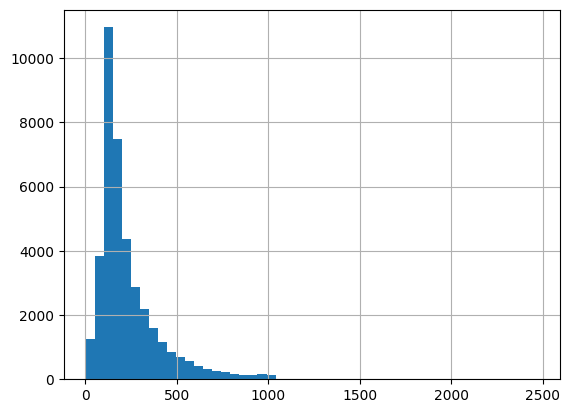

In [9]:
# 2.4 Show histogram of word count
df_train['text'].apply(lambda x: len(x.split(' '))).hist(bins=50)
plt.show()

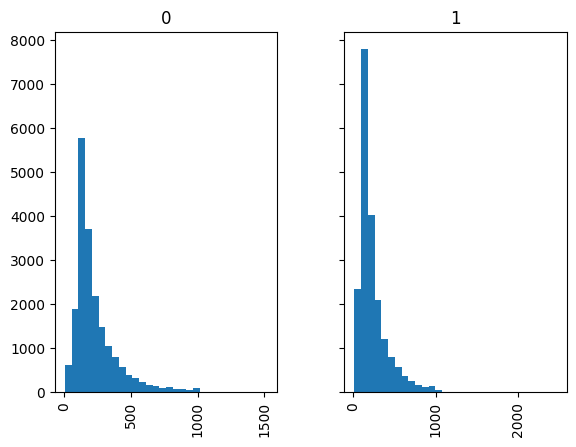

In [10]:
# 2.5 Show histogram of word count stratified by sentiment
(df_train
 .assign(word_count = df_train['text'].apply(lambda x: len(x.split())))
 .hist('word_count', by='label', sharey=True, bins=30)
)
plt.show()

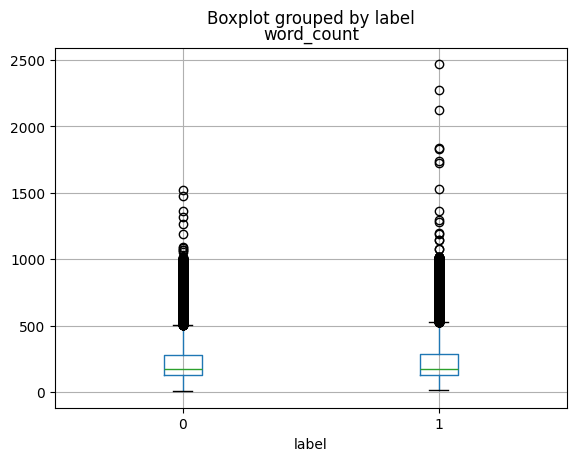

In [11]:
# 2.6 Show boxplot of word count stratified by sentiment
(df_train
 .assign(word_count = df_train['text'].apply(lambda x: len(x.split())))
 .boxplot('word_count', by='label')
)
plt.show()

In [12]:
# 2.7 List total words in our vocabulary
df_train['text'].str.split(expand=True).stack().value_counts().count()

381542

In [13]:
# 2.8 List most frequent words in reviews
df_train['text'].str.split(expand=True).stack().value_counts()[:20]

the      452256
a        244575
and      240627
of       225606
to       208322
is       161625
in       134916
I        105373
that     100888
this      90419
it        86062
/><br     80215
was       73678
as        66287
with      65521
for       64469
The       53448
but       52912
on        48626
movie     48440
Name: count, dtype: int64

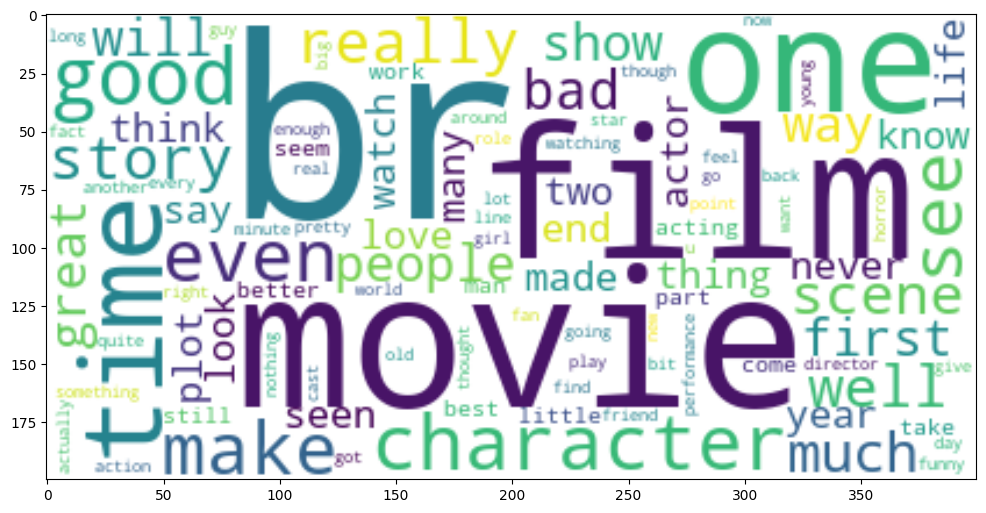

In [14]:
# 2.9 View the wordcloud of reviews without stopwords
text = ' '.join(i.lower() for i in df_train['text'])
wordcloud = WordCloud(max_words=100, 
                      stopwords=None, 
                      background_color='White', 
                      collocations=False).generate(text)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

After analyzing the dataset, we need to create a processing pipeline that:
- removes stopwords
- removes html tags
- removes punctuations
- uses a compact vocabulary
- lowercases the words
- corrects mispelled words like soooo, muuuuch, etc (more than 3 vowels)
- encode sentiment into 1 or 0 

For our traning task, we can split longest reviews into segments or just 
truncate the review up to 500 words and eliminate the rest, but it 
results in losing some information, so we will try both aproaches

In [15]:
# Step 3. Create a NN model iterations
################### Bag of words - Unigram case ########################
# 3.1 Create tensorflow dataset
def make_data(dataset):
    return tf.data.Dataset.from_tensor_slices(
        (
            {'text':dataset['text']},
            dataset['label']
        )
    )
train = make_data(df_train).batch(32)
val = make_data(df_val).batch(32)
test = make_data(df_test).batch(32)

2024-02-28 17:19:02.403561: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-02-28 17:19:02.403601: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-02-28 17:19:02.403612: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-02-28 17:19:02.403849: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-28 17:19:02.404021: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
# 3.2 Create functions to process text on TF string tensors
def custom_standardization_fn(string_tensor):
    '''
    This function does remove blank spaces, lowercases the text, removes 
    html tags, reduces whitespaces, sets spaces after comma, replaces 
    tripple representations of vowels and removes punctuations 
    '''
    stripped_string = tf.strings.strip(string_tensor)
    lowercase_string = tf.strings.lower(stripped_string)
    tagless_string = tf.strings.regex_replace(lowercase_string, '<.*?>', '')
    single_space_string = tf.strings.regex_replace(tagless_string, '\s+',' ')
    comma_space_string = tf.strings.regex_replace(single_space_string, '\s,\s',', ')
    simple_vowel_a_string = tf.strings.regex_replace(comma_space_string, 'a{3,}', 'a')
    simple_vowel_e_string = tf.strings.regex_replace(simple_vowel_a_string, 'e{3,}', 'e')
    simple_vowel_i_string = tf.strings.regex_replace(simple_vowel_e_string, 'i{3, }', 'i')
    simple_vowel_o_string = tf.strings.regex_replace(simple_vowel_i_string, 'o{3, }', 'o')
    simple_vowel_u_string = tf.strings.regex_replace(simple_vowel_o_string, 'u{3, }', 'u')
    stripped_string_again = tf.strings.strip(simple_vowel_u_string)
    return tf.strings.regex_replace(stripped_string_again,
                                    f"[{re.escape(string.punctuation)}]",'')

def custom_split_fn(string_tensor):
    '''
    This function splits the string tensor
    '''
    return tf.strings.split(string_tensor)

In [17]:
# 3.3 Create the vectorization layer and function adapted to train
def create_vectorize_layer(train, feature):
    vectorize_layer = TextVectorization(
        standardize=custom_standardization_fn,
        split=custom_split_fn,
        max_tokens=20000,
        output_mode='count',
        #output_sequence_length=20000
    )
    vectorize_layer.adapt(train.map(lambda x, y: x[feature]))
    return vectorize_layer

vectorize_text = create_vectorize_layer(train, 'text')

2024-02-28 17:19:02.527670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [18]:
# 3.4 Expand the tf datasets applying vectorization
binary_1gram_train_ds = train.map(
    lambda x,y: (vectorize_text(x['text']), y), 
    num_parallel_calls=4)

binary_1gram_val_ds = val.map(
    lambda x,y: (vectorize_text(x['text']), y), 
    num_parallel_calls=4)

binary_1gram_test_ds = test.map(
    lambda x,y: (vectorize_text(x['text']), y), 
    num_parallel_calls=4)

for inputs, targets in binary_1gram_train_ds:
    print('Inputs.shape', inputs.shape)
    print('Targets.shape', targets.shape)
    print('Inputs[0]', inputs[0])
    print('Targets[0]', targets[0])
    break

Inputs.shape (32, 20000)
Targets.shape (32,)
Inputs[0] tf.Tensor([7. 7. 3. ... 0. 0. 0.], shape=(20000,), dtype=float32)
Targets[0] tf.Tensor(0, shape=(), dtype=int64)


In [19]:
# 3.5 Create the model, nn architecture and callback, printing the model
def get_model(max_tokens=20000, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation='relu')(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = get_model()
callbacks = [
    keras.callbacks.ModelCheckpoint('checkpoints/01_model_binary_1gram.keras',
                                    save_best_only=True)
]
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense (Dense)               (None, 16)                320016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320033 (1.22 MB)
Trainable params: 320033 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/10
1242/1242 [==============================] - 12s 10ms/step - loss: 0.3767 - accuracy: 0.8442 - val_loss: 0.2834 - val_accuracy: 0.8848
Epoch 2/10
1242/1242 [==============================] - 12s 9ms/step - loss: 0.2482 - accuracy: 0.9094 - val_loss: 0.2729 - val_accuracy: 0.8930
Epoch 3/10
1242/1242 [==============================] - 12s 9ms/step - loss: 0.2143 - accuracy: 0.9246 - val_loss: 0.2770 - val_accuracy: 0.8940
Epoch 4/10
1242/1242 [==============================] - 12s 9ms/step - loss: 0.2001 - accuracy: 0.9302 - val_loss: 0.2803 - val_accuracy: 0.8944
Epoch 5/10
1242/1242 [==============================] - 12s 9ms/step - loss: 0.1923 - accuracy: 0.9336 - val_loss: 0.2823 - val_accuracy: 0.8936
Epoch 6/10
1242/1242 [==============================] - 12s 9ms/step - loss: 0.1866 - accuracy: 0.9366 - val_loss: 0.2850 - val_accuracy: 0.8936
Epoch 7/10
1242/1242 [==============================] - 12s 9ms/step - loss: 0.1812 - accuracy: 0.9388 - val_loss: 0.2848 - val_a

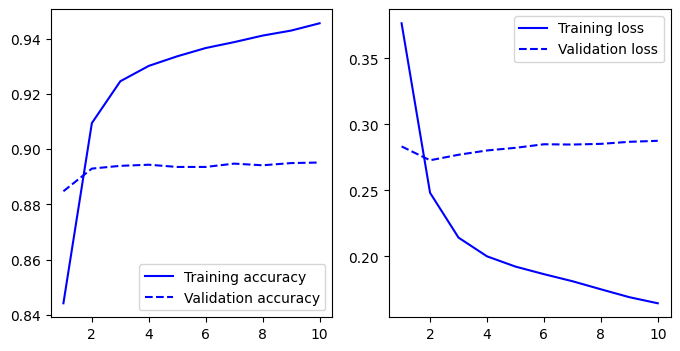

In [20]:
# 3.6 Train the model and get metrics
import matplotlib.pyplot as plt
mymodel = model.fit(binary_1gram_train_ds.cache(),
                    validation_data=binary_1gram_val_ds.cache(),
                    epochs=10,
                    callbacks=callbacks)
plot_accuracy_loss_tfmodel(mymodel,10)

157/157 [==============================] - 1s 6ms/step - loss: 0.2796 - accuracy: 0.9008
Test acc: 0.901
157/157 [==============================] - 0s 3ms/step


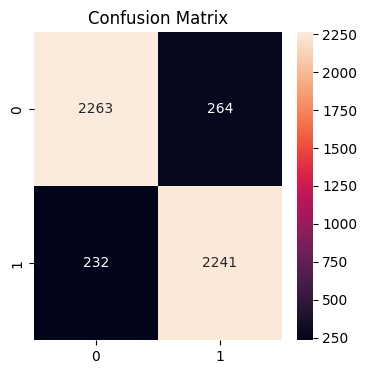

              precision    recall  f1-score   support

         0.0       0.91      0.90      0.90      2527
         1.0       0.89      0.91      0.90      2473

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



In [21]:
# 3.7 Evaluate the model on the test dataset
model = keras.models.load_model('checkpoints/01_model_binary_1gram.keras')
print(f'Test acc: {model.evaluate(binary_1gram_test_ds)[1]:.3f}')
y_pred = model.predict(binary_1gram_test_ds).round()
plot_confusion_matrix(y_pred=y_pred, y_true=df_test.label)

In [22]:
# 3.8 Analyze wrong predictions on validation dataset
y_pred = model.predict(binary_1gram_val_ds).round()
analyze_wrong_predictions(dataset=df_val, y_pred=y_pred, samples=10)

157/157 [==============================] - 0s 3ms/step
label: 1, after seeing this film for the 3rd time now i think it is almost Adam's worst film PUNCH DRUNK LOVE IS POOR in comparison to this i must say at the end when Dickie gets thrown of the boat it is so funny (the hair is different to his and i like it when he flips everyone off. This film should only be brought if your a true Adam Sandler fan.<br /><br />the characters are poor in comparison to his funny films like the Waterboy, which has the same people in it (Peter Dante) who is one of the assassins trying to kill the Australian bird.<br /><br />this film lack depth and a decent story line and deserves to be in the bottom 100
--------------------------------
label: 1, One of the things that makes this Ealing comedy so outrageously funny is the clever editing. Shots that would be considered absolutely essential to most modern comedies are deliberately left out. (This is what was known as British understatement.) <br /><br />T

In [23]:
################### Bag of words - Bigram case #########################
# 3.9 Create the vectorization layer and function adapted to train
def create_vectorize_layer(train, feature):
    vectorize_layer = TextVectorization(
        standardize=custom_standardization_fn,
        split=custom_split_fn,
        max_tokens=20000,
        output_mode='count',
        ngrams=2
        #output_sequence_length=20000
    )
    vectorize_layer.adapt(train.map(lambda x, y: x[feature]))
    return vectorize_layer

vectorize_text = create_vectorize_layer(train, 'text')

In [24]:
# 3.10 Expand the tf datasets applying vectorization
binary_2gram_train_ds = train.map(
    lambda x,y: (vectorize_text(x['text']), y), 
    num_parallel_calls=4)

binary_2gram_val_ds = val.map(
    lambda x,y: (vectorize_text(x['text']), y), 
    num_parallel_calls=4)

binary_2gram_test_ds = test.map(
    lambda x,y: (vectorize_text(x['text']), y), 
    num_parallel_calls=4)

for inputs, targets in binary_2gram_train_ds:
    print('Inputs.shape', inputs.shape)
    print('Targets.shape', targets.shape)
    print('Inputs[0]', inputs[0])
    print('Targets[0]', targets[0])
    break

Inputs.shape (32, 20000)
Targets.shape (32,)
Inputs[0] tf.Tensor([119.   7.   3. ...   0.   0.   0.], shape=(20000,), dtype=float32)
Targets[0] tf.Tensor(0, shape=(), dtype=int64)


In [25]:
# 3.11 Create the model, nn architecture and callback, printing the model
def get_model(max_tokens=20000, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation='relu')(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = get_model()
callbacks = [
    keras.callbacks.ModelCheckpoint('checkpoints/01_model_binary_2gram.keras',
                                    save_best_only=True)
]
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_2 (Dense)             (None, 16)                320016    
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320033 (1.22 MB)
Trainable params: 320033 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/10
1242/1242 [==============================] - 13s 10ms/step - loss: 0.4188 - accuracy: 0.8298 - val_loss: 0.2932 - val_accuracy: 0.8874
Epoch 2/10
1242/1242 [==============================] - 12s 10ms/step - loss: 0.2369 - accuracy: 0.9166 - val_loss: 0.2726 - val_accuracy: 0.8990
Epoch 3/10
1242/1242 [==============================] - 12s 10ms/step - loss: 0.1925 - accuracy: 0.9365 - val_loss: 0.2686 - val_accuracy: 0.9044
Epoch 4/10
1242/1242 [==============================] - 12s 10ms/step - loss: 0.1719 - accuracy: 0.9448 - val_loss: 0.2786 - val_accuracy: 0.9024
Epoch 5/10
1242/1242 [==============================] - 12s 10ms/step - loss: 0.1628 - accuracy: 0.9484 - val_loss: 0.2835 - val_accuracy: 0.9022
Epoch 6/10
1242/1242 [==============================] - 12s 10ms/step - loss: 0.1577 - accuracy: 0.9508 - val_loss: 0.2883 - val_accuracy: 0.9006
Epoch 7/10
1242/1242 [==============================] - 12s 10ms/step - loss: 0.1547 - accuracy: 0.9523 - val_loss: 0.2880 -

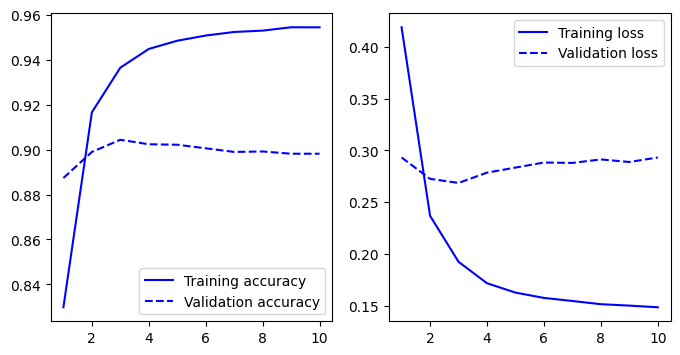

In [26]:
# 3.12 Train the model and get the metrics
mymodel = model.fit(binary_2gram_train_ds.cache(),
                    validation_data=binary_2gram_val_ds.cache(),
                    epochs=10,
                    callbacks=callbacks)

plot_accuracy_loss_tfmodel(mymodel, 10)

157/157 [==============================] - 1s 6ms/step - loss: 0.2680 - accuracy: 0.9072
Test accuracy overall: 0.907
157/157 [==============================] - 0s 3ms/step


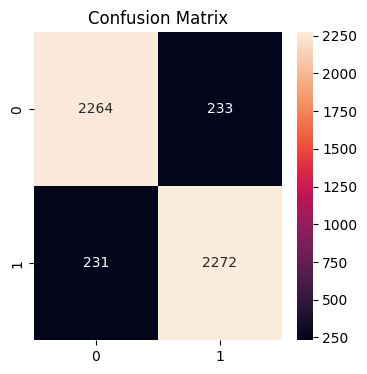

              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91      2497
         1.0       0.91      0.91      0.91      2503

    accuracy                           0.91      5000
   macro avg       0.91      0.91      0.91      5000
weighted avg       0.91      0.91      0.91      5000



In [27]:
# 3.13 Evaluate the model on the test dataset
model = keras.models.load_model('checkpoints/01_model_binary_2gram.keras')
print(f'Test accuracy overall: {model.evaluate(binary_2gram_test_ds)[1]:.3f}')
y_pred = model.predict(binary_2gram_test_ds).round()
plot_confusion_matrix(y_pred=y_pred, y_true=df_test.label)

In [29]:
# 3.14 Analyze wrong predictions on validation dataset
y_pred = model.predict(binary_2gram_val_ds).round()
analyze_wrong_predictions(dataset=df_val, y_pred=y_pred, samples=10)

157/157 [==============================] - 0s 3ms/step
label: 0, This is easily one of the worst movies i have ever seen. There is so much at the house that goes wrong that would not happen it isn't even funny. Granted this is a movie meaning things that won't happen in normal life happen here, however this movie is more far fetched than theories that no child left behind is working. All of these people are in the house and nobody has noticed another, not to mention the damn owl that seems to be coming everywhere but in its cage. I could deal with an owl joke the first few times, but after an hour i just can't take it, i would rather kill myself than see that damn owl again. Did i laugh during this movie? no. Not even once? no. Horrible, Horrible, Horrible. The fact that this pile of garbage is capped off with Ashton Kutcher bending his boss over and taking his pants off in front of everybody just makes this movie ever worse. But wait, the day is saved because the damn owl can fly. WOW

In [30]:
################## Sequence of words - LSTM case #######################
# 3.15 Create the vectorization layer and function adapted to train
def create_vectorize_layer(train, feature):
    vectorize_layer = TextVectorization(
        standardize=custom_standardization_fn,
        split=custom_split_fn,
        max_tokens=20000,
        output_mode='int',
        output_sequence_length=600
    )
    vectorize_layer.adapt(train.map(lambda x, y: x[feature]))
    return vectorize_layer

vectorize_text = create_vectorize_layer(train, 'text')

In [31]:
# 3.16 Expand the tf datasets applying vectorization
binary_lstm_train_ds = train.map(
    lambda x,y: (vectorize_text(x['text']), y), 
    num_parallel_calls=4)

binary_lstm_val_ds = val.map(
    lambda x,y: (vectorize_text(x['text']), y), 
    num_parallel_calls=4)

binary_lstm_test_ds = test.map(
    lambda x,y: (vectorize_text(x['text']), y), 
    num_parallel_calls=4)

for inputs, targets in binary_lstm_train_ds:
    print('Inputs.shape', inputs.shape)
    print('Targets.shape', targets.shape)
    print('Inputs[0]', inputs[0])
    print('Targets[0]', targets[0])
    break

Inputs.shape (32, 600)
Targets.shape (32,)
Inputs[0] tf.Tensor(
[   10  2090    55   952  8802   147     3  1792     2  9152    31    57
  5807    30   373   275    72   245  9152   155   373   287  5935     3
   101   373    72    31   438     6    26 16955    39  1108    53    28
   438     6    26  1796  8144   183    35   663   849    33   537   807
    10   522    57   471     6    64     2    17  1343    34    56    75
     4  3024     5    47    10   409    14     4   543    85 12350  1348
     2    61   317   223    13     2  7826   757  3038    22    12     9
    96  1547    15     2   209   571     5     2  9152  2539   395  2290
     1    28   696  1191   126   285  5689     5     2   207 12799  2498
     3    24   329  1037     1     1   139   578     8    24   688  3014
    24   315    13   322  4680     4   435     5    19  1984  1867     4
  1586   992   194    26  3371    18  9428     1    15 18379     1     1
     1    13     4   598  6080     5  5809     0     0     0

In [32]:
# 3.17 Create the model, nn architecture and callback, printing the model
def get_model(max_tokens=20000, hidden_dim=16):
    inputs = keras.Input(shape=(None,), dtype='int64')
    embedded = tf.one_hot(inputs, depth=max_tokens)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = get_model()
callbacks = [
    keras.callbacks.ModelCheckpoint('checkpoints/01_model_binary_lstm.keras',
                                    save_best_only=True)
]
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 20000)       0         
                                                                 
 bidirectional (Bidirection  (None, 64)                5128448   
 al)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5128513 (19.56 MB)
Trainable params: 5128513 (19.56 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

Epoch 1/10
1242/1242 [==============================] - 371s 297ms/step - loss: 0.4518 - accuracy: 0.8036 - val_loss: 0.5932 - val_accuracy: 0.8213
Epoch 2/10
1242/1242 [==============================] - 388s 312ms/step - loss: 0.3072 - accuracy: 0.8901 - val_loss: 0.2830 - val_accuracy: 0.8876
Epoch 3/10
1242/1242 [==============================] - 367s 295ms/step - loss: 0.2509 - accuracy: 0.9097 - val_loss: 0.2868 - val_accuracy: 0.8988
Epoch 4/10
1242/1242 [==============================] - 366s 295ms/step - loss: 0.2254 - accuracy: 0.9194 - val_loss: 0.3073 - val_accuracy: 0.8972
Epoch 5/10
1242/1242 [==============================] - 389s 313ms/step - loss: 0.2011 - accuracy: 0.9297 - val_loss: 0.3062 - val_accuracy: 0.8902
Epoch 6/10
1242/1242 [==============================] - 365s 294ms/step - loss: 0.1791 - accuracy: 0.9382 - val_loss: 0.3239 - val_accuracy: 0.8928
Epoch 7/10
1242/1242 [==============================] - 370s 298ms/step - loss: 0.1590 - accuracy: 0.9436 - val_

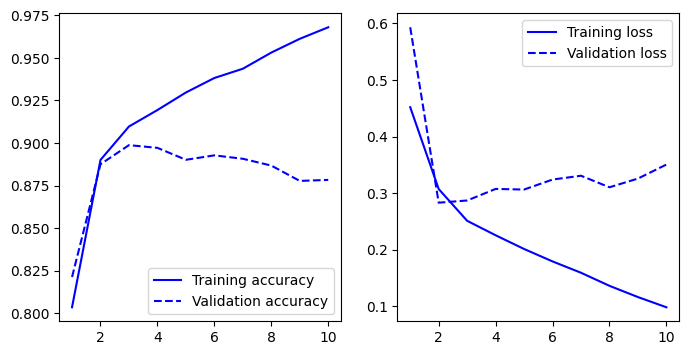

In [33]:
# 3.18 Train the model and get the metrics
mymodel = model.fit(binary_lstm_train_ds.cache(),
                    validation_data=binary_lstm_val_ds.cache(),
                    epochs=10,
                    batch_size=8,
                    callbacks=callbacks)

plot_accuracy_loss_tfmodel(mymodel, 10)

In [ ]:
# 3.19 Evaluate the model on the test dataset
model = keras.models.load_model('checkpoints/01_model_binary_lstm.keras')
print(f'Test accuracy overall: {model.evaluate(binary_lstm_test_ds)[1]:.3f}')
y_pred = model.predict(binary_lstm_test_ds).round()
plot_confusion_matrix(y_pred=y_pred, y_true=df_test.label)

In [ ]:
# 3.20 Analyze wrong predictions on validation dataset
y_pred = model.predict(binary_lstm_val_ds).round()
analyze_wrong_predictions(dataset=df_val, y_pred=y_pred, samples=10)

In [34]:
############ Sequence of words - LSTM w/embeddings case ################
# 3.21 Create the vectorization layer and function adapted to train
def create_vectorize_layer(train, feature):
    vectorize_layer = TextVectorization(
        standardize=custom_standardization_fn,
        split=custom_split_fn,
        max_tokens=20000,
        output_mode='int',
        output_sequence_length=600
    )
    vectorize_layer.adapt(train.map(lambda x, y: x[feature]))
    return vectorize_layer

vectorize_text = create_vectorize_layer(train, 'text')

In [35]:
# 3.22 Expand the tf datasets applying vectorization
binary_lstm_embedding_train_ds = train.map(
    lambda x,y: (vectorize_text(x['text']), y), 
    num_parallel_calls=4)

binary_lstm_embedding_val_ds = val.map(
    lambda x,y: (vectorize_text(x['text']), y), 
    num_parallel_calls=4)

binary_lstm_embedding_test_ds = test.map(
    lambda x,y: (vectorize_text(x['text']), y), 
    num_parallel_calls=4)

for inputs, targets in binary_lstm_train_ds:
    print('Inputs.shape', inputs.shape)
    print('Targets.shape', targets.shape)
    print('Inputs[0]', inputs[0])
    print('Targets[0]', targets[0])
    break

Inputs.shape (32, 600)
Targets.shape (32,)
Inputs[0] tf.Tensor(
[   10  2090    55   952  8802   147     3  1792     2  9152    31    57
  5807    30   373   275    72   245  9152   155   373   287  5935     3
   101   373    72    31   438     6    26 16955    39  1108    53    28
   438     6    26  1796  8144   183    35   663   849    33   537   807
    10   522    57   471     6    64     2    17  1343    34    56    75
     4  3024     5    47    10   409    14     4   543    85 12350  1348
     2    61   317   223    13     2  7826   757  3038    22    12     9
    96  1547    15     2   209   571     5     2  9152  2539   395  2290
     1    28   696  1191   126   285  5689     5     2   207 12799  2498
     3    24   329  1037     1     1   139   578     8    24   688  3014
    24   315    13   322  4680     4   435     5    19  1984  1867     4
  1586   992   194    26  3371    18  9428     1    15 18379     1     1
     1    13     4   598  6080     5  5809     0     0     0

In [36]:
# 3.23 Create the model, nn architecture and callback, printing the model
def get_model(max_tokens=20000, hidden_dim=16):
    inputs = keras.Input(shape=(None,), dtype='int64')
    embedded = layers.Embedding(input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = get_model()
callbacks = [
    keras.callbacks.ModelCheckpoint('checkpoints/01_model_binary_lstm_embedding.keras',
                                    save_best_only=True)
]
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         5120000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                73984     
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5194049 (19.81 MB)
Trainable params: 5194049 (19.81 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

Epoch 1/10
1242/1242 [==============================] - 175s 139ms/step - loss: 0.4195 - accuracy: 0.8237 - val_loss: 0.3133 - val_accuracy: 0.8766
Epoch 2/10
1242/1242 [==============================] - 161s 130ms/step - loss: 0.2874 - accuracy: 0.8924 - val_loss: 0.3125 - val_accuracy: 0.8782
Epoch 3/10
1242/1242 [==============================] - 160s 129ms/step - loss: 0.2446 - accuracy: 0.9114 - val_loss: 0.3146 - val_accuracy: 0.8862
Epoch 4/10
1242/1242 [==============================] - 160s 129ms/step - loss: 0.2026 - accuracy: 0.9279 - val_loss: 0.3292 - val_accuracy: 0.8952
Epoch 5/10
1242/1242 [==============================] - 161s 130ms/step - loss: 0.1668 - accuracy: 0.9419 - val_loss: 0.2922 - val_accuracy: 0.8958
Epoch 6/10
1242/1242 [==============================] - 161s 130ms/step - loss: 0.1375 - accuracy: 0.9534 - val_loss: 0.3146 - val_accuracy: 0.8952
Epoch 7/10
1242/1242 [==============================] - 160s 129ms/step - loss: 0.1174 - accuracy: 0.9600 - val_

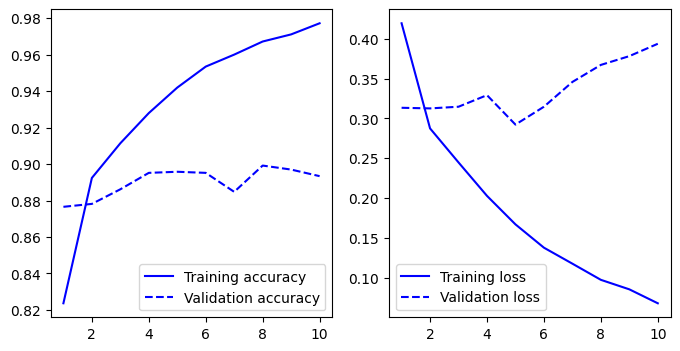

In [37]:
# 3.24 Train the model and get the metrics
mymodel = model.fit(binary_lstm_embedding_train_ds.cache(),
                    validation_data=binary_lstm_embedding_val_ds.cache(),
                    epochs=10,
                    batch_size=8,
                    callbacks=callbacks)

plot_accuracy_loss_tfmodel(mymodel, 10)

157/157 [==============================] - 7s 35ms/step - loss: 0.2716 - accuracy: 0.8996
Test accuracy overall: 0.900
157/157 [==============================] - 5s 31ms/step


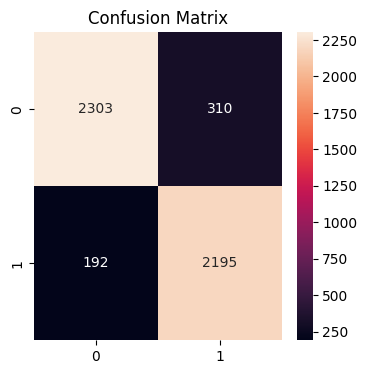

              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90      2613
         1.0       0.88      0.92      0.90      2387

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



In [38]:
# 3.25 Evaluate the model on the test dataset
model = keras.models.load_model('checkpoints/01_model_binary_lstm_embedding.keras')
print(f'Test accuracy overall: {model.evaluate(binary_lstm_embedding_test_ds)[1]:.3f}')
y_pred = model.predict(binary_lstm_embedding_test_ds).round()
plot_confusion_matrix(y_pred=y_pred, y_true=df_test.label)

In [ ]:
# 3.14 Analyze wrong predictions on validation dataset
y_pred = model.predict(binary_lstm_embedding_val_ds).round()
analyze_wrong_predictions(dataset=df_val, y_pred=y_pred, samples=10)